<a href="https://colab.research.google.com/github/yvonnemliu/DS_Takehome_Challenges/blob/main/DS_Takehome_Challenges_ABTesting_EngagementTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Modules

In [1]:
import datetime as dt
import random as rd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from IPython.core.pylabtools import figsize
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
from scipy import stats


sns.set_style('whitegrid')
figsize(20, 5)
plt.rcParams.update({'font.size': 10})


from google.cloud import bigquery
from google.colab import auth, drive, files
from oauth2client.client import GoogleCredentials

auth.authenticate_user() # Authenticates Access 
print('Authenticated') 
drive.mount('/content/drive') # Authenticates access to google drive. Useful for downloading data already on the drive
print("Drive Authenticated")


Authenticated
Mounted at /content/drive
Drive Authenticated


In [2]:
import datetime
from datetime import date

## Load Data

In [3]:
test = pd.read_csv('drive/MyDrive/Engagement_Test/test_table.csv')
user = pd.read_csv('drive/MyDrive/Engagement_Test/user_table.csv')

## Assessing Data

In [4]:
test.head()

,user_id,date,browser,test,pages_visited
0,600597,2015-08-13,IE,0,2
1,4410028,2015-08-26,Chrome,1,5
2,6004777,2015-08-17,Chrome,0,8
3,5990330,2015-08-27,Safari,0,8
4,3622310,2015-08-07,Firefox,0,1


In [5]:
user.head()

,user_id,signup_date
0,34,2015-01-01
1,59,2015-01-01
2,178,2015-01-01
3,285,2015-01-01
4,383,2015-01-01


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        100000 non-null  int64 
 1   date           100000 non-null  object
 2   browser        100000 non-null  object
 3   test           100000 non-null  int64 
 4   pages_visited  100000 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.8+ MB


In [7]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   user_id      100000 non-null  int64 
 1   signup_date  100000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [8]:
# timestamp should be datetime instead of strings.
test.date = pd.to_datetime(test.date)

In [9]:
# Next, I want to see if there are any duplicated rows that I need to get rid of.
# Looks like there are no duplicate rows.
sum(test.duplicated()), sum(user.duplicated())

(0, 0)

In [10]:
# Let's merge the two datasets.
df = pd.merge(test,  
                     user,  
                     on ='user_id',  
                     how ='outer')

In [11]:
test.shape[0]-test.user_id.nunique(), user.shape[0]-user.user_id.nunique()

(0, 0)

In [12]:
# calculate the number of rows of the "test" dataset and the "user" dataset.
test.shape[0], user.shape[0]


(100000, 100000)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        100000 non-null  int64         
 1   date           100000 non-null  datetime64[ns]
 2   browser        100000 non-null  object        
 3   test           100000 non-null  int64         
 4   pages_visited  100000 non-null  int64         
 5   signup_date    100000 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 5.3+ MB


In [14]:
def pages(df):
    n = {}
    n['n_purchase'] = df.shape[0]# number of purchase in that day
    n['pages_visited'] = df.pages_visited.sum() # total pages visited in that day
    n['n_customer'] = df.user_id.nunique() # how many customers access the store that day
    return pd.Series(n)

In [15]:
df_by_day = df.groupby(['date','test']).apply(pages)

In [16]:
df_by_day

n_purchase  pages_visited  n_customer
date       test                                       
2015-08-01 0           1173           5344        1173
           1           1228           5664        1228
2015-08-02 0           1228           5524        1228
           1           1174           5381        1174
2015-08-03 0           1792           8359        1792
...                     ...            ...         ...
2015-08-29 1           1207           5573        1207
2015-08-30 0           1200           5458        1200
           1           1198           5463        1198
2015-08-31 0           1875           8650        1875
           1           1736           7910        1736

[62 rows x 3 columns]

In [17]:
def user_metrics(df):
  d = []
  col_names = ['pages_visited']
  test_data = df.loc[df['test'] == 1,:]
  ctrl_data = df.loc[df['test'] == 0,:]
  for col in col_names:
    test_mean = test_data[col].mean()
    ctrl_mean = ctrl_data[col].mean()
    result = stats.ttest_ind(test_data[col],
                           ctrl_data[col],
                           equal_var = False)
    d.append({'mean_test':test_mean,
              'mean_control':ctrl_mean,
              'mean_diff':test_mean - ctrl_mean, 
              'pvalue': result.pvalue/2,
              'stat_sig': 'stat sig' if result.pvalue/2 <= 0.05 else 'not stat sig'
                       })
   # 
  return pd.DataFrame(d,index = col_names).\
  loc[:,['mean_test','mean_control','mean_diff','pvalue', 'stat_sig']]

In [19]:
user_metrics(df)

,mean_test,mean_control,mean_diff,pvalue,stat_sig
pages_visited,4.599693,4.608394,-0.008701,0.288726,not stat sig


### Question 1: Is the test winning? That is, should 100% of the users see the Recommended Friends feature?

### Answer: 
* Based on the table above, there is not enough evidence to suggest that there are improvements in `pages_visited` in test vs. control (test group's `pages_visited` mean came in at 4.5997, slightly lower than control group's 4.6084. The p-value of 0.2887 was also higher than the 0.05 significance level). 

* That said, if we further slice the data by `browser`, we observed stat sig improvements in Chrome, Firefox, and IE. 

* Opera seems to have experienced some technical issues after launching the Recommended Friends feature in the test group because the average `pages_visited` in the test group dropped to 0 vs. the control group's 4.546. This could indicate issues like broken links after users click on the system recommended potential friends in their newsfeeds. 

* Further, Safari's `page_visited` increased; however, the increase was not stat sig. 

In [20]:
df.groupby('browser').apply(user_metrics)


,,mean_test,mean_control,mean_diff,pvalue,stat_sig
browser,,,,,,
Chrome,pages_visited,4.690680,4.613341,0.077339,4.717042e-04,stat sig
Firefox,pages_visited,4.714259,4.600164,0.114095,2.908599e-04,stat sig
IE,pages_visited,4.685985,4.598478,0.087507,3.914755e-03,stat sig
Opera,pages_visited,0.000000,4.546438,-4.546438,1.126470e-321,stat sig
Safari,pages_visited,4.692336,4.638180,0.054156,1.205869e-01,not stat sig


### Question 2: Is the test performing similarly for all user segments or are there differences among different segments?

### Answer: 

In [21]:
df.head()

,user_id,date,browser,test,pages_visited,signup_date
0,600597,2015-08-13,IE,0,2,2015-01-19
1,4410028,2015-08-26,Chrome,1,5,2015-05-11
2,6004777,2015-08-17,Chrome,0,8,2015-06-26
3,5990330,2015-08-27,Safari,0,8,2015-06-25
4,3622310,2015-08-07,Firefox,0,1,2015-04-17


In [22]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['first_session_signup_date_delta'] = (df['date'] - df['signup_date']).astype('timedelta64[D]')

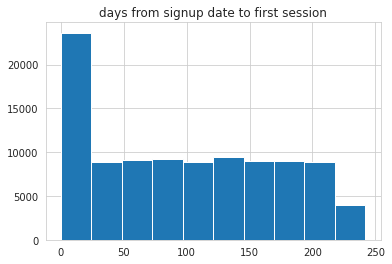

In [23]:
df['first_session_signup_date_delta'].hist()
plt.title('days from signup date to first session')
plt.show()

In [24]:
df['first_session_signup_date_delta'].describe()

count    100000.000000
mean         97.020210
std          73.627085
min           0.000000
25%          29.000000
50%          94.000000
75%         161.000000
max         242.000000
Name: first_session_signup_date_delta, dtype: float64

In [25]:
df["window"] = pd.cut(df['first_session_signup_date_delta'], bins=[0, 1, 7, 14, 30, 250], include_lowest=True, 
                    labels=['0-1 day','2-7 days','8-14 days','15-30 days','31-242 days'])

In [26]:
df.groupby('window').agg(
    {'first_session_signup_date_delta': ['min','max']}
)

first_session_signup_date_delta       
                                        min    max
window                                            
0-1 day                                 0.0    1.0
2-7 days                                2.0    7.0
8-14 days                               8.0   14.0
15-30 days                             15.0   30.0
31-242 days                            31.0  242.0

**Preliminary Results**:
For users who had their first sessions right after they signed up (within a day), there is sufficient evidence to support that the Recommended Friends feature had a negative effect on average `pages_visited` as the metric decreased 2.6% from 4.6288 to 4.5097. 

For users who signed up but did not have their first sessions right away, the new feature's impact on `pages_visited` are not statistically significant. 

We suggest taking it with a grain of salt because the results presented in this text block might be swayed by the technical issues in the **Opera** browser. We will now 1) remove **Opera** data from `df` as well as 2) taking a look at a data breakout by `browser` and `first_session_signup_date_delta`.

In [27]:
df.groupby('window').apply(user_metrics)

,,mean_test,mean_control,mean_diff,pvalue,stat_sig
window,,,,,,
0-1 day,pages_visited,4.509652,4.628804,-0.119152,0.000918,stat sig
2-7 days,pages_visited,4.358621,4.765060,-0.406440,0.067650,not stat sig
8-14 days,pages_visited,4.655914,4.709677,-0.053763,0.365349,not stat sig
15-30 days,pages_visited,4.688431,4.616792,0.071639,0.165965,not stat sig
31-242 days,pages_visited,4.618806,4.600469,0.018337,0.149242,not stat sig


In [28]:
df_no_opera = df.query('browser != "Opera"')
df_no_opera.groupby('window').apply(user_metrics)

,,mean_test,mean_control,mean_diff,pvalue,stat_sig
window,,,,,,
0-1 day,pages_visited,4.594688,4.635084,-0.040396,1.459632e-01,not stat sig
2-7 days,pages_visited,4.450704,4.777778,-0.327074,1.145307e-01,not stat sig
8-14 days,pages_visited,4.779249,4.721491,0.057758,3.544891e-01,not stat sig
15-30 days,pages_visited,4.806379,4.611511,0.194868,4.022828e-03,stat sig
31-242 days,pages_visited,4.715234,4.600777,0.114457,3.375666e-11,stat sig


After we removed the "Opera" `browser`:

As shown in the table above, the Recommended Friends feature had a statistically significant positive impact on the average `page_visited` metric of users who started a session 15-242 days after signing up. This makes sense because our algorithm has collected more data on these users during the two weeks after their signup date and the potential friends recommendations will likely resonate better with these users. 

Next, we would like to further slice up the data by browser and window: 
* based on the table below, the Recommended Friends feature had stat sig positive impact on **Chrome** and **Firefox** users who visited the website (first session) at least a month after they signed up. For **IE** users, we observed positive impact on `pages_visited` for users who started a session at least 2 weeks after they signed up. 
* **Safari** users did not benefit from this new feature. 

In [29]:
df_browser_window = df.groupby(['browser','window']).apply(user_metrics)

In [30]:
df_browser_window

mean_test  ...      stat_sig
browser window                                ...              
Chrome  0-1 day     pages_visited   4.649820  ...  not stat sig
        2-7 days    pages_visited   4.649123  ...  not stat sig
        8-14 days   pages_visited   4.746193  ...  not stat sig
        15-30 days  pages_visited   4.773679  ...  not stat sig
        31-242 days pages_visited   4.696219  ...      stat sig
Firefox 0-1 day     pages_visited   4.539220  ...  not stat sig
        2-7 days    pages_visited   4.064516  ...  not stat sig
        8-14 days   pages_visited   4.807339  ...  not stat sig
        15-30 days  pages_visited   4.900609  ...  not stat sig
        31-242 days pages_visited   4.750499  ...      stat sig
IE      0-1 day     pages_visited   4.544627  ...  not stat sig
        2-7 days    pages_visited   4.368421  ...  not stat sig
        8-14 days   pages_visited   4.841584  ...  not stat sig
        15-30 days  pages_visited   4.729897  ...      stat sig
        31-242 days pages_visited   4.720996  ...      stat sig
Opera   0-1 day     pages_visited   0.000000  ...      stat sig
        2-7 days    pages_visited   0.000000  ...      stat sig
        8-14 days   pages_visited   0.000000  ...      stat sig
        15-30 days  pages_visited   0.000000  ...      stat sig
        31-242 days pages_visited   0.000000  ...      stat sig
Safari  0-1 day     pages_visited   4.578657  ...  not stat sig
        2-7 days    pages_visited   4.687500  ...  not stat sig
        8-14 days   pages_visited   4.717391  ...  not stat sig
        15-30 days  pages_visited   4.902041  ...  not stat sig
        31-242 days pages_visited   4.710080  ...  not stat sig

[25 rows x 5 columns]

In [31]:
df_browser_window.loc[df_browser_window['stat_sig'] == "stat sig",:]

mean_test  ...  stat_sig
browser window                                ...          
Chrome  31-242 days pages_visited   4.696219  ...  stat sig
Firefox 31-242 days pages_visited   4.750499  ...  stat sig
IE      15-30 days  pages_visited   4.729897  ...  stat sig
        31-242 days pages_visited   4.720996  ...  stat sig
Opera   0-1 day     pages_visited   0.000000  ...  stat sig
        2-7 days    pages_visited   0.000000  ...  stat sig
        8-14 days   pages_visited   0.000000  ...  stat sig
        15-30 days  pages_visited   0.000000  ...  stat sig
        31-242 days pages_visited   0.000000  ...  stat sig

[9 rows x 5 columns]

### Question 3: If you identified segments that responded differently to the test, can you guess the reason? Would this change your conclusions?

### Answer: 
- Cold start problem: new incoming users usually experience the “cold start problem” as they are lacking browsing history and there are not enough signals for a prediction. 
- In contrast, after a period of time after a user signs up, our system has collected enough data on that user to make solid friend recommendations. As a result, it makes sense to observe a stat sig increase in `pages_visited` for Chrome, Firefox, and IE after a certain period of time. 

### Appendix: 
- We have also studied the feature's impact on daily `pages_visited` metric. There are no stat sig differences observed from any segments. The `Opera` browser had stat sig differences, but it was likely due to technical problems. 

In [48]:
def daily_metrics(df):
  d = []
  col_names = ['pages_visited']
  df_by_day = df.groupby(['date','test']).apply(pages)
  df_by_day.index = df_by_day.index.get_level_values('test')
  df_test = df_by_day.loc[df_by_day.index == 1,:]
  df_ctrl = df_by_day.loc[df_by_day.index == 0,:]
  for col in col_names:
    test_mean = df_test[col].mean()
    ctrl_mean = df_ctrl[col].mean()
    result = stats.ttest_ind(df_test[col],
                           df_ctrl[col],
                           equal_var = False)
    d.append({'mean_test':test_mean,
                       'mean_control':ctrl_mean,
                       'mean_diff':test_mean - ctrl_mean, 
                       'pvalue': result.pvalue/2,
              'stat_sig': 'stat sig' if result.pvalue/2 <= 0.05 else 'not stat sig'
                       })
   # 
  return pd.DataFrame(d,index = col_names).\
  loc[:,['mean_test','mean_control','mean_diff','pvalue','stat_sig']]


In [52]:
df.groupby('browser').apply(daily_metrics)

,,mean_test,mean_control,mean_diff,pvalue,stat_sig
browser,,,,,,
Chrome,pages_visited,3324.935484,3192.580645,132.354839,1.893987e-01,not stat sig
Firefox,pages_visited,1640.258065,1628.161290,12.096774,4.382500e-01,not stat sig
IE,pages_visited,1658.838710,1617.774194,41.064516,2.985007e-01,not stat sig
Opera,pages_visited,0.000000,162.645161,-162.645161,2.766456e-19,stat sig
Safari,pages_visited,817.677419,808.838710,8.838710,4.095727e-01,not stat sig


In [53]:
daily_metrics(df)

,mean_test,mean_control,mean_diff,pvalue,stat_sig
pages_visited,7441.709677,7410.0,31.709677,0.462221,not stat sig


In [56]:
df.groupby(['browser','window']).apply(daily_metrics)

mean_test  ...      stat_sig
browser window                                  ...              
Chrome  0-1 day     pages_visited   667.774194  ...  not stat sig
        2-7 days    pages_visited    37.857143  ...  not stat sig
        8-14 days   pages_visited    66.785714  ...  not stat sig
        15-30 days  pages_visited   159.600000  ...  not stat sig
        31-242 days pages_visited  2464.000000  ...  not stat sig
Firefox 0-1 day     pages_visited   311.741935  ...  not stat sig
        2-7 days    pages_visited    18.000000  ...  not stat sig
        8-14 days   pages_visited    40.307692  ...  not stat sig
        15-30 days  pages_visited    83.310345  ...  not stat sig
        31-242 days pages_visited  1229.612903  ...  not stat sig
IE      0-1 day     pages_visited   321.935484  ...  not stat sig
        2-7 days    pages_visited    27.666667  ...  not stat sig
        8-14 days   pages_visited    34.928571  ...  not stat sig
        15-30 days  pages_visited    79.103448  ...  not stat sig
        31-242 days pages_visited  1241.774194  ...  not stat sig
Opera   0-1 day     pages_visited     0.000000  ...      stat sig
        2-7 days    pages_visited     0.000000  ...      stat sig
        8-14 days   pages_visited     0.000000  ...      stat sig
        15-30 days  pages_visited     0.000000  ...      stat sig
        31-242 days pages_visited     0.000000  ...      stat sig
Safari  0-1 day     pages_visited   160.548387  ...  not stat sig
        2-7 days    pages_visited    12.500000  ...  not stat sig
        8-14 days   pages_visited    18.083333  ...  not stat sig
        15-30 days  pages_visited    41.413793  ...  not stat sig
        31-242 days pages_visited   608.967742  ...  not stat sig

[25 rows x 5 columns]